### Load packages, set default plotting parameters and define helper functions

In [1]:
# load packages
#import packages
import scipy
import scipy.integrate

import xarray as xr 

from xgcm import Grid

import pandas as pd

import statsmodels
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FixedLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import random as rand

import statsmodels.tsa.api as smt

from pyleoclim import utils
#from pyleoclim import tsutils
from pyleoclim.utils import tsutils
matplotlib.rcParams.update(plt.rcParamsDefault)

import cmocean

import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

#%%set default font properties for plots
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
font = {'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
half_width=3.5 #width of 1/2 page figure
full_width=7 #with of full page figure

#function to calculate trophic position
def TP(Glu,Phe,beta=3.4,d=3.4,TDF=7.6,coral=True):
    if coral == True:
        TP_val=((Glu+d-Phe-beta)/TDF)+1
    if coral == False:
        TP_val=((Glu-Phe-beta)/TDF)+1
    return TP_val

#function to calculate spearman correlation coefficient
def rho_calc(TP_series,Phe_series):
    rho=scipy.stats.spearmanr(TP_series,Phe_series)[0]
    return rho

#function to calculate linear regression slope
def slope_calc(TP_series,Phe_series):
    slope=scipy.stats.linregress(TP_series,Phe_series)[0]
    return slope

#function to calculate linear regression intercept
def intercept_calc(TP_series,Phe_series):
    intercept=scipy.stats.linregress(TP_series,Phe_series)[1]
    return intercept

#function to estimate lag-1 autocorrelation from irregularly spaced timeseries
def lag1ac(age,y,step_mult=0.9):
    y_vals,time_vals=y.values,age.values
    step_width=(max(time_vals)-min(time_vals))/len(time_vals)
    y_interp_time,y_interp=tsutils.interp(time_vals, y_vals, interp_type='nearest',
                                          stop=max(time_vals)+(step_width/2), 
                                          #step_style='median',
                                          step=step_width*step_mult,
                                          bounds_error=False,fill_value='extrapolate')
    lag1ac=smt.acf(y_interp,nlags=1,fft=True)[1]
    return lag1ac,y_interp_time,y_interp

# function that plots a 2d 95% confidence ellipse 
# taken from: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Load and process actual paleoceanographic amino acid d15N datasets, calculate TP and lag-1 ac and other descriptive statistics, load info into one summary dataframe

SR nointerp phe lag-1 ac 0.10515507561498516
SR interp phe lag-1 ac 0.14215115759240568
SR nointerp tp lag-1 ac 0.01358739570731754
SR interp tp lag-1 ac 0.16296364619664777


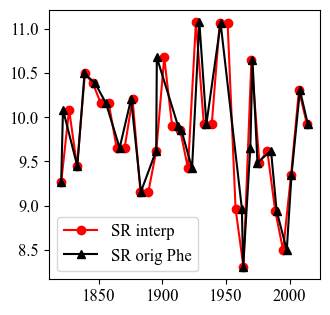

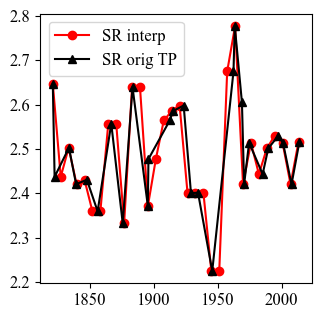

PI nointerp phe lag-1 ac 0.05471968784422516
PI interp phe lag-1 ac 0.09666332543488564
PI nointerp tp lag-1 ac 0.34027440862668684
PI interp tp lag-1 ac 0.3024519231978916


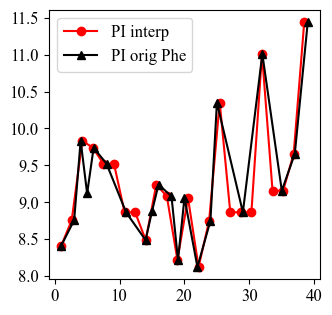

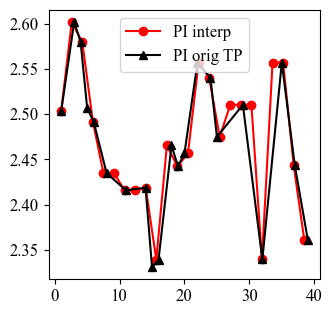

MC nointerp phe lag-1 ac 0.06631150152312244
MC interp phe lag-1 ac 0.14558956129161554
MC nointerp tp lag-1 ac -0.030015062058959742
MC interp tp lag-1 ac 0.058180088774036555


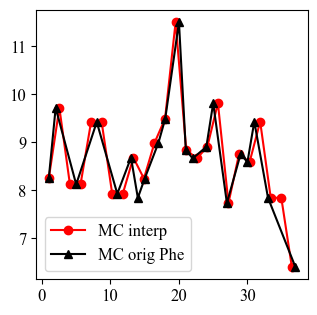

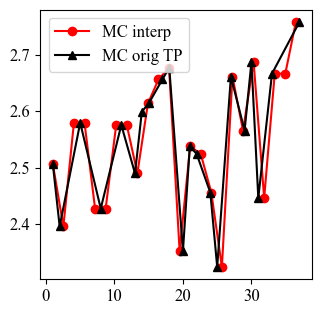

NPSG nointerp phe lag-1 ac 0.48598733318253773
NPSG interp phe lag-1 ac 0.5820257899729495
NPSG nointerp tp lag-1 ac -0.27996653239543834
NPSG interp tp lag-1 ac -0.03306043329246852


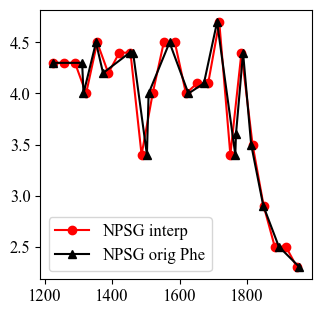

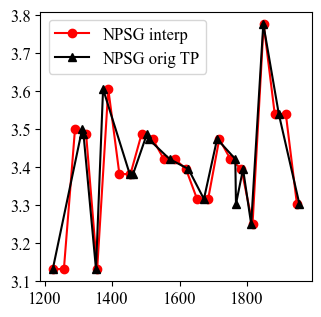

KR nointerp phe lag-1 ac 0.17283154121863814
KR interp phe lag-1 ac 0.22433183769020684
KR nointerp tp lag-1 ac 0.39591533733858125
KR interp tp lag-1 ac 0.435399872296272


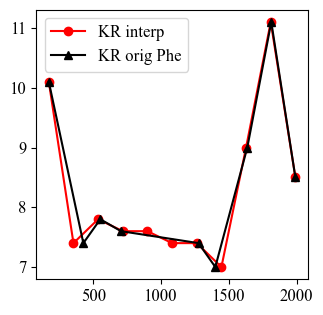

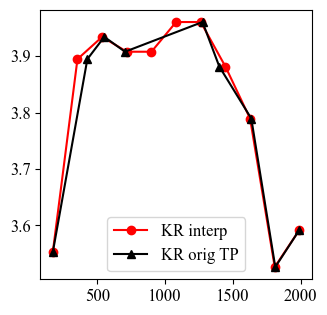

ET nointerp phe lag-1 ac 0.09702916347238451
ET interp phe lag-1 ac 0.19953295284734507
ET nointerp tp lag-1 ac -0.12691270872120505
ET interp tp lag-1 ac 0.031032217283632237


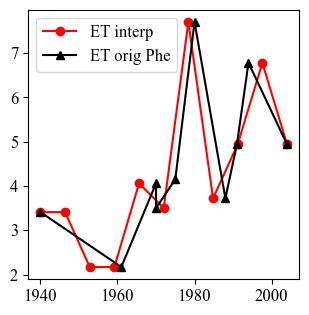

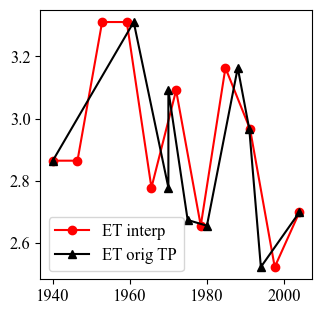

SWT nointerp phe lag-1 ac -0.3962902465322724
SWT interp phe lag-1 ac -0.352268541129977
SWT nointerp tp lag-1 ac -0.37108152060832506
SWT interp tp lag-1 ac -0.3347419256803719


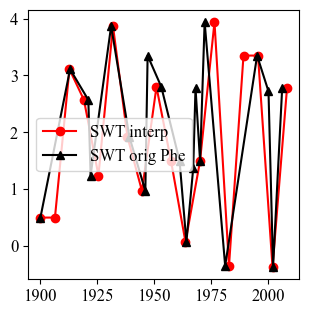

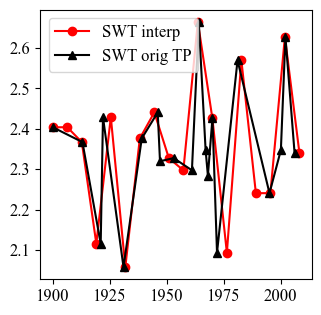

LHR nointerp phe lag-1 ac 0.33882074030285597
LHR interp phe lag-1 ac 0.37085268328667
LHR nointerp tp lag-1 ac 0.4001114642698721
LHR interp tp lag-1 ac 0.49247548292498144


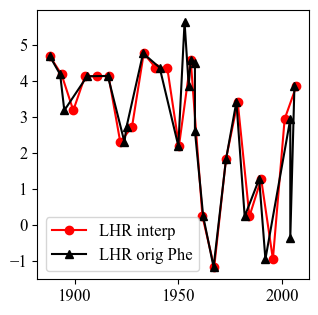

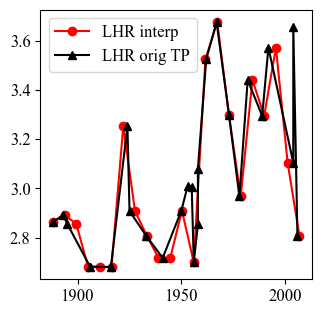

BS nointerp phe lag-1 ac 0.699371927519465
BS interp phe lag-1 ac 0.8009030979160956
BS nointerp tp lag-1 ac 0.3103720619693515
BS interp tp lag-1 ac 0.4774934271792198


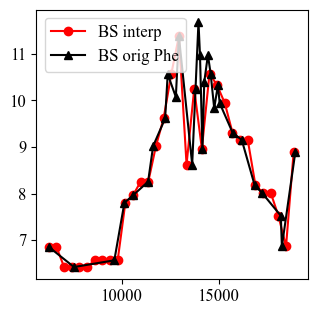

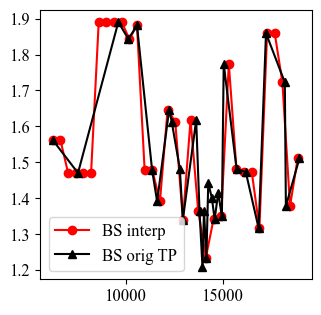

SBB nointerp phe lag-1 ac -0.018953068592057695
SBB interp phe lag-1 ac 0.17298507566147486
SBB nointerp tp lag-1 ac 0.17333333333333353
SBB interp tp lag-1 ac 0.21312260536398467


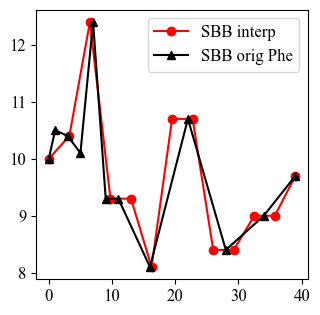

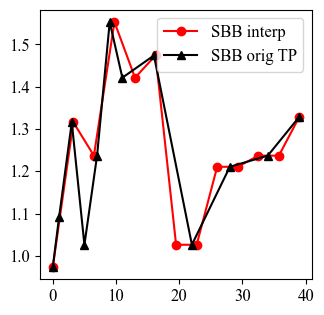

In [2]:
#Load Actual d15N datasets, process and summarize them

#names of dataset worksheets in .xlsx file
datasets=['Pugsley_SR','Shen_Pioneer','Shen_MontereyCanyon','Sherwood_gold','Glynn_equatorial',
          'Strzepek_ETas','Strzepek_SWTas','Strzepek_LHR','Delong_Bering','Batista_SBB']

# abbreviations to use for each study site
abbrev_list=['SR','PI','MC','NPSG','KR',
             'ET','SWT','LHR','BS','SBB']

# if dataset is a coral record, True
# if sediment record, False
coral_list=[True,True,True,True,True,
            True,True,True,False,False]

# latitude, longitude and depth for each study site
# for records with multiple coral collected close by, 
# the mean value is given
lat_list=[36.4, 37.359, 36.744, 21.29, 6.38, 
          -42.5, -45.3, -27.85, 53.4, 34.23]

lon_list=[-122.3,-123.394,-122.037,-157.54,-162.42,
          149.25,145.35,161.85,-179.52,-120.03]

depth_list=[1250, 1300, 870, 450, 400,
            1200, 2400, 1550, 1300, 450]

# step_mult values to input into
# lag1ac function. These have been 
# tuned manually so the interpolation 
# matches the original dataset well,
# to try to get a pretty accurate lag-1 
# autocorrelation value
step_mult_list=[.9,.9,.9,.9,.9,
                1,1.2,1.2,.9,1]

# create empty lists we will populate in a loop
age_obs_list=[]
Glu_obs_list=[]
Phe_obs_list=[]
Lys_obs_list=[]
TP_obs_list=[]
rho_obs_list=[]
slope_obs_list=[]

mean_list_phe=[]
mean_list_TP=[]
range_list_phe=[]
range_list_TP=[]
auto_list_phe=[]
auto_list_TP=[]
nobs_list=[]

# loop through each dataset in our compilation
for i in range(len(datasets)):

    #read in dataset from excel
    df_dataset=pd.read_excel(r'TP_Phe comparison.xlsx',datasets[i])

    # drop very low unrealistic TP value (<0.5) 
    # from Batista et al. Santa Barbara Basin dataset
    if abbrev_list[i]=='SBB':
        TP_check=TP(df_dataset['Glu'],df_dataset['Phe'],coral=coral_list[i])
        df_dataset=df_dataset.where(TP_check>0.9).dropna()

    #calculate TP
    TP_obs=TP(df_dataset['Glu'],df_dataset['Phe'],coral=coral_list[i])

    # for a few sites we don't have an age model
    # so am using sample id instead to determine lag-1 autocorrelation
    # assuming a constant growth and/or accumulation rate
    if datasets[i] in ['Shen_Pioneer','Shen_MontereyCanyon','Batista_SBB']:
        age_sel=df_dataset['Sample']
    else:
        age_sel=df_dataset['age']

    # create new dataframe with variables of interest from this specific dataset
    sorted_dataframe=pd.DataFrame({'age':age_sel,'Glu':df_dataset['Glu'],
                                   'Phe':df_dataset['Phe'],'Lys':df_dataset['Lys'],
                                   'TP':TP_obs}).sort_values(by='age')
    
    # append timeseries variables onto empty lists you made above
    age_obs_list.append(sorted_dataframe['age'])
    Glu_obs_list.append(sorted_dataframe['Glu'])
    Phe_obs_list.append(sorted_dataframe['Phe'])
    Lys_obs_list.append(sorted_dataframe['Lys'])
    TP_obs_list.append(sorted_dataframe['TP'])

    # calculate the lag-1 autocorrelation coefficient for TP and Phe
    auto_phe,phe_interp_time,phe_interp=lag1ac(sorted_dataframe['age'],sorted_dataframe['Phe'],step_mult=step_mult_list[i])
    auto_TP,TP_interp_time,TP_interp=lag1ac(sorted_dataframe['age'],sorted_dataframe['TP'],step_mult=step_mult_list[i])

    # print lag 1 ac for interpolated vs original timeseries to see what
    # the effect of interpolation is 
    print(abbrev_list[i]+' nointerp phe lag-1 ac',smt.acf(sorted_dataframe['Phe'],nlags=1,fft=True)[1])
    print(abbrev_list[i]+' interp phe lag-1 ac',auto_phe)
    print(abbrev_list[i]+' nointerp tp lag-1 ac',smt.acf(sorted_dataframe['TP'],nlags=1,fft=True)[1])
    print(abbrev_list[i]+' interp tp lag-1 ac',auto_TP)

    # plot the original vs interpolated time series to see how 
    # well the interpolation reproduces the main patterns in the 
    # data. Want to capture main features without adding too 
    # many extra points, which artificially inflates the 
    # autocorrelation coefiicient
    fig,ax=plt.subplots(figsize=(half_width,half_width))
    plt.plot(phe_interp_time,phe_interp,color='r',marker='o',label=abbrev_list[i]+' interp')
    plt.plot(sorted_dataframe['age'],sorted_dataframe['Phe'],color='k',marker='^',label=abbrev_list[i]+' orig Phe')
    plt.legend()
    plt.show()
    plt.close()
    
    fig,ax=plt.subplots(figsize=(half_width,half_width))
    plt.plot(TP_interp_time,TP_interp,color='r',marker='o',label=abbrev_list[i]+' interp')
    plt.plot(sorted_dataframe['age'],sorted_dataframe['TP'],color='k',marker='^',label=abbrev_list[i]+' orig TP')
    plt.legend()
    plt.show()
    plt.close()

    # calculate spearman's rho and the slope 
    # of the linear regression
    # between TP and Phe
    rho_obs=rho_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Phe'])
    m_obs=slope_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Phe'])

    # append stats of interest for each dataset into empty lists we made above
    rho_obs_list.append(np.round(rho_obs,2))
    slope_obs_list.append(np.round(m_obs,1))
    mean_list_phe.append(np.round(np.mean(sorted_dataframe['Phe']),1))
    mean_list_TP.append(np.round(np.mean(sorted_dataframe['TP']),1))
    range_list_phe.append(np.round(max(sorted_dataframe['Phe'])
                          -min(sorted_dataframe['Phe']),1))
    range_list_TP.append(np.round(max(sorted_dataframe['TP'])
                         -min(sorted_dataframe['TP']),1))
    auto_list_phe.append(np.round(auto_phe,2))
    auto_list_TP.append(np.round(auto_TP,2))
    nobs_list.append(len(sorted_dataframe['Phe']))

# create new summary dataframe from all the stats we calculated in the loop 
# above for each dataset
dataframe=pd.DataFrame({'Abbreviation': abbrev_list,
                        'Latitude':np.round(np.asarray(lat_list),1),
                        'Longitude':np.round(np.asarray(lon_list),1),
                        'Water Depth':depth_list,
                        'rho': np.round(np.asarray(rho_obs_list),2),
                        'slope': np.round(np.asarray(slope_obs_list),1),
                        'Phe mean':mean_list_phe,
                        'TP mean':mean_list_TP,
                        'Phe range':range_list_phe,
                        'TP range':range_list_TP,
                        'Phe Lag-1 AC':auto_list_phe,
                        'TP Lag-1 AC':auto_list_TP,
                        '# Obs':nobs_list
                       })

### View resulting summary dataframe and correlations amongst variables

In [4]:
display(dataframe)
display(dataframe.corr(method='spearman',numeric_only=True))

,Abbreviation,Latitude,Longitude,Water Depth,rho,slope,Phe mean,TP mean,Phe range,TP range,Phe Lag-1 AC,TP Lag-1 AC,# Obs
0,SR,36.4,-122.3,1250,-0.71,-4.4,9.8,2.5,2.8,0.6,0.14,0.16,28
1,PI,37.4,-123.4,1300,-0.23,-4.1,9.3,2.5,3.3,0.3,0.10,0.30,21
2,MC,36.7,-122.0,870,-0.68,-6.5,8.7,2.5,5.1,0.4,0.15,0.06,21
3,NPSG,21.3,-157.5,450,-0.22,-1.1,3.9,3.4,2.4,0.6,0.58,-0.03,20
4,KR,6.4,-162.4,400,-0.73,-6.9,8.4,3.8,4.1,0.4,0.22,0.44,9
5,ET,-42.5,149.2,1200,-0.80,-4.9,4.5,2.9,5.5,0.8,0.20,0.03,10
6,SWT,-45.3,145.4,2400,-0.85,-7.3,2.0,2.4,4.3,0.6,-0.35,-0.33,20
7,LHR,-27.8,161.8,1550,-0.80,-5.6,2.8,3.1,6.8,1.0,0.37,0.49,25
8,BS,53.4,-179.5,1300,-0.52,-3.8,9.1,1.5,5.3,0.7,0.80,0.48,29
9,SBB,34.2,-120.0,450,-0.44,-2.6,9.8,1.2,4.3,0.6,0.17,0.21,12


,Latitude,Longitude,Water Depth,rho,slope,Phe mean,TP mean,Phe range,TP range,Phe Lag-1 AC,TP Lag-1 AC,# Obs
Latitude,1.000000,-0.636364,-0.091465,0.717329,0.503030,0.741645,-0.374261,-0.218846,-0.388946,0.103030,0.393939,0.585377
Longitude,-0.636364,1.000000,0.378056,-0.595747,-0.345455,-0.370822,-0.055219,0.534957,0.464226,-0.333333,-0.212121,-0.146344
Water Depth,-0.091465,0.378056,1.000000,-0.422020,-0.262200,-0.302754,-0.345686,0.370032,0.353455,-0.298786,0.079270,0.588957
rho,0.717329,-0.595747,-0.422020,1.000000,0.826752,0.536585,-0.123082,-0.542683,-0.415300,0.224925,0.072949,0.152906
slope,0.503030,-0.345455,-0.262200,0.826752,1.000000,0.474166,-0.214740,-0.322190,0.112920,0.406061,0.078788,0.207321
Phe mean,0.741645,-0.370822,-0.302754,0.536585,0.474166,1.000000,-0.461558,-0.301829,-0.358668,-0.164134,0.291795,0.238533
TP mean,-0.374261,-0.055219,-0.345686,-0.123082,-0.214740,-0.461558,1.000000,-0.153853,-0.025403,0.337449,0.042948,-0.339513
Phe range,-0.218846,0.534957,0.370032,-0.542683,-0.322190,-0.301829,-0.153853,1.000000,0.629242,0.261399,0.340427,0.100918
TP range,-0.388946,0.464226,0.353455,-0.415300,0.112920,-0.358668,-0.025403,0.629242,1.000000,0.501866,0.131740,0.205130
Phe Lag-1 AC,0.103030,-0.333333,-0.298786,0.224925,0.406061,-0.164134,0.337449,0.261399,0.501866,1.000000,0.430303,0.079270


### Fig. 2a load Rafter 2019 d15N ANN output into pandas dataframes and plot with site locations

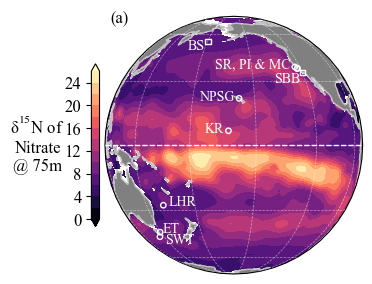

In [5]:
# load Rafter 2019 d15N ANN output into pandas dataframes and plot with site locations

#load Rafter et al., 2019 dataset into pandas dataframe
d15N_df=pd.read_csv(r'dataset-768655_global-model-nitrate-d15n__v1.csv',
                 header=0)

#assign coordinates to indices in pandas 
d15N_df = d15N_df.set_index(['latitude', 'longitude','depth'])

# convert d15N pandas dataframe to xarray DataArray
d15N=d15N_df.to_xarray()
d15N=d15N.d15N

#select depth of interest (if choosing depth already in data)
depth=75
d15N_depth_sel=d15N.sel(depth=depth,method='nearest')

#uncomment this code segment below if want to interpolate to different depth:
# # to interpolate to any depth of choice, must convert dataset to xgcm Grid
# # and use xgcm Grid.transform to interpolate 
# depth=85 #set depth of interest
# # convert xarray dataset to xgcm Grid
# grid = Grid(d15N.to_dataset(), 
#             coords={'X': {'center':'longitude'},
#                     'Y': {'center':'latitude'},
#                     'Z': {'center': 'depth'}},
#             periodic=False)
# # create array with target depth
# target_depth_level = np.asarray([depth])
# # interpolate dataset to target depth
# d15N = grid.transform(d15N.to_dataset().d15N, 'Z', 
#                       target_depth_level, target_data=None, 
#                       method='linear')
# # convert from 3d to 2d for easier plotting by selecting only
# # depth of interest
# d15N_depthsel=d15N.sel(depth=depth)

#make map of sites with modern d15N NO3 from Rafter et al., 2019 

#create list of sampling sites labels from compiled observations
lats_obs=dataframe.Latitude
lons_obs=dataframe.Longitude

#set lat and lon coordinates where you want center of map to be
central_lon,central_lat=-160,0

# initialize plot
fig = plt.figure(figsize=(half_width,half_width))

#select map projection
proj='ortho'

#initialize subplot with chosen map projection
if proj== 'mollweide':
    ax = fig.add_subplot(1, 1, 1, projection=crs.Mollweide(central_longitude=central_lon))
    fraction=0.015
elif proj == 'robinson':
    ax = fig.add_subplot(1, 1, 1, projection=crs.Robinson(central_longitude=central_lon))
    fraction=0.015
elif proj in ['ortho','orthographic']:
    ax = fig.add_subplot(1, 1, 1, projection=crs.Orthographic(central_lon,central_lat))
    fraction=0.03
elif proj in ['pc','PlateCarree']:
    ax = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree(central_longitude=central_lon))
    fraction=0.03
else:
    print("please select one of 'mollweide', 'robinson','pc' or 'ortho'")

#plot deep-sea coral study sites locations
plt.scatter(lons_obs.where(pd.DataFrame(coral_list)[0]==True),
            lats_obs.where(pd.DataFrame(coral_list)[0]==True),
            s=15,color='None',ec='w',
           linestyle='None',marker='o',
           transform=crs.PlateCarree(),zorder=10)
#plot sediment core study site locations
plt.scatter(lons_obs.where(pd.DataFrame(coral_list)[0]==False),
            lats_obs.where(pd.DataFrame(coral_list)[0]==False),
            s=15,color='None',ec='w',
           linestyle='None',marker='s',
           transform=crs.PlateCarree(),zorder=10)

# specify labels to add to each study site 
abbrev=['','','SR, PI & MC','NPSG','KR',
        'ET','SWT','LHR','BS','SBB']

#customize placement of each label
lons_shift=[0, 0, -4, -2, -2,
            4,  3, 4, -1, -3]
lats_shift=[0, 0,  2,  1,  1,
            2, -2, 2, -3, -3]
ha=['left','left','right','right','right',
    'left','left','left','right','right']
for i in np.arange(0,len(abbrev)):
    ax.text(lons_obs[i]+lons_shift[i],
            lats_obs[i]+lats_shift[i],
            abbrev[i], 
            ha=ha[i],va='center',
            fontsize=10,rotation=0,
            color='w',transform=crs.PlateCarree())

# make filled contour plot of the Rafter et al 2019 
# nitrate d15N climatology at selected depth level
contour=ax.contourf(d15N.longitude, d15N.latitude, d15N_depth_sel,
                    levels=np.arange(0,26.1,2),extend='both',
                    cmap='magma',transform=crs.PlateCarree())

#add and configure colorbar settings
cbar=fig.colorbar(contour, orientation='vertical',
                  fraction=fraction, pad=0.02,location='left')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$\mathdefault{δ^{15}N}$ of\nNitrate\n@ '+str(depth)+'m',
               rotation=0,va='center',labelpad=20,fontsize=12)

# add land masses to map
ax.add_feature(NaturalEarthFeature('physical', 'land', '110m'),
               edgecolor='silver',lw=1,facecolor='grey',alpha=1,zorder=1)

#configure gridlines
gl=ax.gridlines(draw_labels=False, crs=crs.PlateCarree(),
             linewidth=.5, color='w', alpha=0.5, linestyle='--',zorder=5)
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
gl.ylocator = mticker.FixedLocator(np.arange(-60,61,30))
gl2=ax.gridlines(draw_labels=False, ylocs=[0],  #special bold gridline for equator
             linewidth=1, color='w', alpha=1, linestyle='--',zorder=5)
gl2.xlines=False

#if projection is PlateCarree, set axis limits
# otherwise get to global coverage
if proj in ['pc','PlateCarree']:
    ax.set_extent([-240, -100, -65, 65],crs=crs.PlateCarree())
else:
    ax.set_global()

# add subplot label
ax.text(0.02,0.98,'(a)',transform=ax.transAxes)

plt.savefig('Figures/Fig2a.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig2a.pdf',bbox_inches='tight', dpi=1000)
plt.show()

### Extract Mean d15N NO3 @ depth selected above at each study site from Rafter et al 2019 neural network climatology dataset

In [6]:
# copy the nitrate d15N climatology xarray Dataset
# and convert latitude from 0-360 to -180 to 180
# so it matches the paleo dataset coordinates
d15N_newlon=d15N
d15N_newlon.coords['longitude'] = (d15N.coords['longitude'] + 180) % 360 - 180
d15N_newlon = d15N_newlon.sortby(d15N.longitude)

# select depth of interest
d15N_depth_sel=d15N_newlon.sel(depth=depth)

# interpolate nitrate d15N climatology dataset to nearest longitude
# in order to fill nan values 
# (was a problem at a few sites very close to land) 
d15N_sel=d15N_depth_sel.interpolate_na(dim='longitude',method='nearest')

# create empty list to populate 
# with d15N NO3 values from each site 
d15N_NO3_list=[]

# loop through each study site,
# find d15N NO3 value at chosen depth
# that's closest to sampling location
for i in dataframe.index:
    d15N_point=d15N_sel.sel(latitude=dataframe['Latitude'].iloc[i],
                            longitude=dataframe['Longitude'].iloc[i],
                            method='nearest')
    d15N_NO3_list.append(np.round(d15N_point.values,2))

# add d15N NO3 values for each study site 
# to the summary dataframe and display the values
dataframe['d15N NO3']=d15N_NO3_list
display(dataframe.loc[:,['Abbreviation','Latitude',
                         'Longitude','d15N NO3']])

,Abbreviation,Latitude,Longitude,d15N NO3
0,SR,36.4,-122.3,9.23
1,PI,37.4,-123.4,9.44
2,MC,36.7,-122.0,9.23
3,NPSG,21.3,-157.5,7.52
4,KR,6.4,-162.4,13.61
5,ET,-42.5,149.2,6.82
6,SWT,-45.3,145.4,8.03
7,LHR,-27.8,161.8,7.35
8,BS,53.4,-179.5,6.52
9,SBB,34.2,-120.0,7.94


### Figure 2b plot TP vs Phe corrected to site-specific d15N NO3 value

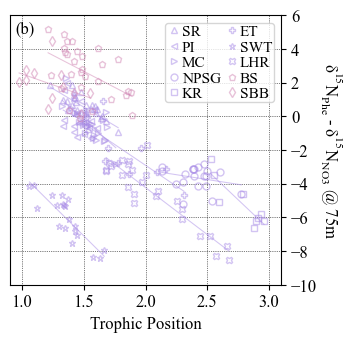

In [8]:
# set markers to used for each study site
marker_list=['^','<','>','o','s',
             'P','*','X','p','d']

# set colors to use for sed records
# and coral records, respectively
sedcolor='#D186B4'#'#CC7AA0'#
coralcolor='#A78AE6'#'#126C7A'

# initialize plot 
fig,ax=plt.subplots(figsize=(half_width,half_width))

# loop through the compiled paleo datasets
# plotting TP vs d15N Phe normalized to d15N NO3 
# from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
for i in dataframe.index:
    if coral_list[i]==True:
        mec_sel=coralcolor #select color
        # correct TP for offset between coral
        # and dietary POM
        TP_sel=TP_obs_list[i]-1 
    else:
        mec_sel=sedcolor #select color
        # no correction for sediment datasets
        TP_sel=TP_obs_list[i]
    Phe_calc=Phe_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    # plot TP vs Phe points
    plt.plot(TP_sel,
             Phe_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker=marker_list[i],
             label=dataframe['Abbreviation'].iloc[i])

    # calculate slope and intercept for the TP-Phe
    # regression in each dataset and plot
    m=scipy.stats.linregress(TP_sel,Phe_calc)[0]
    b=scipy.stats.linregress(TP_sel,Phe_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,linestyle='-',alpha=.5,
             lw=.75,color=mec_sel)

# set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Phe}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m',
             rotation=270,labelpad=20)

#set axis limits
ax.set_xlim(0.9,3.1)
ax.set_ylim(-10,6)

# move y axis ticks and axis label to right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

# add legend
ax.legend(fontsize=11,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))

# add subplot label
text=ax.text(0.02,0.98,'(b)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#save figure, display and close
plt.savefig('Figures/Fig2b.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig2b.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()


### Supplementary figure TP vs Lys

In [ ]:
# marker_list=['o','x','s','^','v','d','*','p','P','<']
marker_list=['^','<','>','o','s',
             'P','*','X','p','d']
sedcolor='#D186B4'#'#CC7AA0'#
coralcolor='#A78AE6'#'#126C7A'

fig,ax=plt.subplots(figsize=(half_width,half_width))
for i in dataframe.index:
    if coral_list[i]==True:
        mec_sel=coralcolor
        TP_sel=TP_obs_list[i]-1
        Lys_calc=Lys_obs_list[i]-dataframe['d15N NO3'].iloc[i]-((TP_obs_list[i]-1)*1)
    else:
        mec_sel=sedcolor
        TP_sel=TP_obs_list[i]
        Lys_calc=Lys_obs_list[i]-dataframe['d15N NO3'].iloc[i]-((TP_sel-1)*1)
    plt.plot(TP_sel,
             Lys_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker=marker_list[i],
             label=dataframe['Abbreviation'].iloc[i])
    m=scipy.stats.linregress(TP_sel,Lys_calc)[0]
    b=scipy.stats.linregress(TP_sel,Lys_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,
             linestyle='--',
             alpha=.5,
             color=mec_sel)

ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Lys}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m')

ax.set_xlim(0.9,3.1)
ax.set_ylim(-8,5)

ax.grid(linestyle=':',color='k',lw=.5)
ax.legend(fontsize=10,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))

plt.savefig('Figures/Supplemental_TPvLys_corr.png',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()


In [ ]:
# marker_list=['o','x','s','^','v','d','*','p','P','<']
marker_list=['^','<','>','o','s',
             'P','*','X','p','d']
sedcolor='#D186B4'#'#CC7AA0'#
coralcolor='#A78AE6'#'#126C7A'

fig,ax=plt.subplots(figsize=(half_width,half_width))
for i in dataframe.index:
    if coral_list[i]==True:
        mec_sel=coralcolor
        TP_sel=TP_obs_list[i]-1
        Lys_calc=Lys_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    else:
        mec_sel=sedcolor
        TP_sel=TP_obs_list[i]
        Lys_calc=Lys_obs_list[i]-dataframe['d15N NO3'].iloc[i]
    plt.plot(TP_sel,
             Lys_calc,
             linestyle='None',color='None',
             mec=mec_sel,alpha=.5,ms=5,
             marker=marker_list[i],
             label=dataframe['Abbreviation'].iloc[i])
    m=scipy.stats.linregress(TP_sel,Lys_calc)[0]
    b=scipy.stats.linregress(TP_sel,Lys_calc)[1]
    x=np.asarray([min(TP_sel),max(TP_sel)])
    plt.plot(x,m*x+b,
             linestyle='--',
             alpha=.5,
             color=mec_sel)

ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Lys}}$ - $\mathdefault{δ^{15}N_{NO3}}$ @ 75m')

ax.set_xlim(0.9,3.1)
ax.set_ylim(-6,5)

ax.grid(linestyle=':',color='k',lw=.5)
ax.legend(fontsize=10,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))

plt.savefig('Figures/Supplemental_TPvLys_uncorr.png',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()


### Spurious Correlations Analysis

In [ ]:
#Are Glu vals normal?
fig,ax=plt.subplots()
#bin_edges=np.arange(19,23,.5)
ax.grid(linestyle=':',zorder=-20)
ax.hist(Glu_actual_SR, bins=5, density=False,edgecolor=(.4,0,.6,1), color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Actual d15N Glu')
plt.ylabel('# Observations')
plt.xlabel('d15N Glu')
#ax.set_xlim(-1,0)
plt.legend()
plt.show()
plt.close()

#Are Phe vals normal?
fig,ax=plt.subplots()
#bin_edges=np.arange(19,23,.5)
ax.grid(linestyle=':',zorder=-20)
ax.hist(Phe_actual_SR, bins=5, density=False,edgecolor=(.4,0,.6,1), color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Actual d15N Phe')
plt.ylabel('# Observations')
plt.xlabel('d15N Phe')
#ax.set_xlim(-1,0)
plt.legend()
plt.show()
plt.close()

#Is TP normal?
fig,ax=plt.subplots()
#bin_edges=np.arange(19,23,.5)
ax.grid(linestyle=':',zorder=-20)
ax.hist(TP_actual_SR, bins=5, density=False,edgecolor=(.4,0,.6,1), color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Actual TP')
plt.ylabel('# Observations')
plt.xlabel('TP')
#ax.set_xlim(-1,0)
plt.legend()
plt.show()
plt.close()

In [ ]:
#calculate 10,000 Glu and Phe datasets
def scale(series,low,high):
    newseries=(high-low)*((series-min(series))/(max(series)-min(series)))+low
    return newseries

# def correlation_theoretical_orig(Phe_actual=Phe_actual,Glu_actual=Glu_actual,TP_actual=TP_actual,time=age_actual,
#                             n=len(Glu_actual),nsims=10000,
#                             test='spearman',uncertainty_dist='normal',
#                             Glu_std=0.6,Phe_std=0.7,
#                             TP_range=[2.2,2.8],
#                             Phe_TDF=0.4, Glu_TDF=8.0,
#                             baseline_variability=True,
#                             measurement_uncertainty=True,
#                             TDF_uncertainty=True,
#                             beta_uncertainty=True,
#                             autocorrelation=True):
#     Phe_sims=[]
#     TP_sims=[]
#     rho_sims=[]
#     p_sims=[]
    
#     #autocorrelation info for actual TP timeseries 
#     step_width=(max(time)-min(time))/len(time)
#     interp_time,interp_TP=tsutils.interp(time, TP_actual, interp_type='linear', step=step_width)
#     lag1ac_TP=0.9#smt.acf(interp_TP,nlags=1,fft=False)[1]
#     ar_TP = [1, -lag1ac_TP]  # AR model parameter
#     ma_TP = [1, 0.0] # MA model parameters
    
#     #autocorrelation info for actual Phe timeseries 
#     interp_time,interp_Phe=tsutils.interp(time, Phe_actual, interp_type='linear', step=step_width)
#     lag1ac_Phe=0.9#smt.acf(interp_Phe,nlags=1,fft=False)[1]
#     ar_Phe = [1, -lag1ac_Phe]  # AR model parameter
#     ma_Phe = [1, 0.0] # MA model parameters
        
#     for i in range(0,nsims):
        
#             # accounts for the effects of autocorrelation in TP, which is often high in paleo timeseries
#             if autocorrelation==True:
#                 TP_true=smt.arma_generate_sample(ar_TP, ma_TP, nsample=n,
#                                                         distrvs=np.random.uniform,
#                                                         burnin=50)
#                 TP_true=scale(TP_true,low=TP_range[0],high=TP_range[1])
#             elif autocorrelation==False:
#                 TP_true=np.random.uniform(TP_range[0],TP_range[1], n)
#                 TP_true=scale(TP_true,low=TP_range[0],high=TP_range[1])

#             # define baseline Phe values (can be constant or variable)
#             if baseline_variability == True:
#                 #accounts for effects of autocorrelation in baseline Phe timeseries
#                 if autocorrelation == True:
#                     Phe_baseline=smt.arma_generate_sample(ar_Phe, ma_Phe, nsample=n,
#                                                             distrvs=np.random.uniform,
#                                                             burnin=50)
#                     Phe_baseline=scale(Phe_baseline,low=min(Phe_actual),high=max(Phe_actual))
#                 elif autocorrelation == False:
#                     Phe_baseline=np.random.uniform(Phe_actual.min()-1, Phe_actual.max()+1, n)
#             elif baseline_variability == False:
#                 Phe_baseline=np.full(n,Phe_actual.mean())

#             # Account for trophic fractionation variability
#             TDF_Glu=np.full(n,Glu_TDF)
#             TDF_Phe=np.full(n,Phe_TDF)
            
#             if TDF_uncertainty == True:
#                 if uncertainty_dist == 'uniform':
#                     TDF_Glu=TDF_Glu+np.random.uniform(-1,1, n) #can use this to add in uncertainty associated with TDF
#                     TDF_Phe=TDF_Phe+np.random.uniform(-.4,.4, n) #can use this to add in uncertainty associated with TDF
#                 elif uncertainty_dist == 'normal':
#                     TDF_Glu=TDF_Glu+np.random.normal(0, 1, n)
#                     TDF_Phe=TDF_Phe+np.random.normal(0, .4, n)
            
#             #Calculate true sample values for d15N Phe and Glu
#             Phe_true=Phe_baseline+((TP_true-1)*TDF_Phe)
#             Glu_true=Phe_baseline+((TP_true-1)*TDF_Glu)
            
#             #Account for Beta variability by adding some uncertainty to Glu values 
#             # using the nonvascular autotroph beta uncertainty of 1.8 permil from Ramirez et al. 2021
#             if beta_uncertainty == True:
#                 if uncertainty_dist == 'uniform':
#                     Glu_true=Glu_true+np.random.uniform(-1.8,1.8, n)
#                 elif uncertainty_dist == 'normal':
#                     Glu_true=Glu_true+np.random.normal(0, 1.8, n)
            
#             if measurement_uncertainty == True:
#                 #account for d15N Phe measurement uncertainty
#                 if uncertainty_dist == 'uniform':
#                     Phe_meas=Phe_true+np.random.uniform(-2*Phe_std, 2*Phe_std, n)
#                     Glu_meas=Glu_true+np.random.uniform(-2*Glu_std, 2*Glu_std, n)
#                 elif uncertainty_dist == 'normal':
#                     Phe_meas=Phe_true+np.random.normal(0, Phe_std, n)
#                     Glu_meas=Glu_true+np.random.normal(0, Glu_std, n)
#             elif measurement_uncertainty == False:
#                 Phe_meas=Phe_true
#                 Glu_meas=Glu_true
            
#             #calculate a measured TP value 
#             TP_meas=TP(Glu=Glu_meas,Phe=Phe_meas)
            
#             #calculate correlation coefficients
#             if test == 'pearson':
#                 rho=scipy.stats.pearsonr(TP_meas,Phe_meas)[0]
#                 p=scipy.stats.pearsonr(TP_meas,Phe_meas)[1]
#             if test == 'spearman':
#                 rho=scipy.stats.spearmanr(TP_meas,Phe_meas)[0]
#                 p=scipy.stats.spearmanr(TP_meas,Phe_meas)[1]
                
#             #save results
#             Phe_sims.append(Phe_meas)
#             TP_sims.append(TP_meas)
#             rho_sims.append(rho)
#             p_sims.append(p)
            
#             if i < 10:
#                 fig,ax=plt.subplots()
#                 ax.plot(interp_time,TP_true,color='k',alpha=.5,linestyle=':')
#                 ax.plot(interp_time,TP_meas,color='k')
#                 ax2=ax.twinx()
#                 ax2.plot(interp_time,Phe_baseline,color='g',alpha=.5,linestyle=':')
#                 ax2.plot(interp_time,Phe_true,color='g',alpha=.5,linestyle='--')
#                 ax2.plot(interp_time,Phe_meas,color='g')
#                 ax.set_ylabel('TP')
#                 ax2.set_ylabel('Phe')
#                 plt.show()
#                 plt.close()
            
#     return Phe_sims,TP_sims,rho_sims,p_sims
        
def correlation_theoretical(n=len(Glu_actual_SR),nsims=10000,
                            test='spearman',uncertainty_dist='normal',
                            TP_range=[2.2,2.8],
                            baseline_range=[8.5,10.5], #if baseline_variability=False can just be single number
                            Phe_TDF=0.4, Glu_TDF=8.0,
                            Phe_TDF_std=0,Glu_TDF_std=0,
                            lag1ac_TP=0,lag1ac_Phe=0,
                            Glu_meas_std=0.6,Phe_meas_std=0.7,
                            beta=3.4, beta_std=1.8,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                            d=3.4,d_std=0.1,         #correction for polyp-skeleton offset, from McMahon et al
                            baseline_variability=False,
                            coral=True,reg=False):
    Phe_sims=[]
    Glu_sims=[]
    TP_sims=[]
    rho_sims=[]
    p_sims=[]
    
    if reg == True:
        slope_sims=[]
    
    #autocorrelation info for TP timeseries 
    ar_TP = [1, -lag1ac_TP]  # AR model parameter
    ma_TP = [1, 0.0] # MA model parameters
    
    #autocorrelation info for Phe timeseries 
    ar_Phe = [1, -lag1ac_Phe]  # AR model parameter
    ma_Phe = [1, 0.0] # MA model parameters
        
    for i in range(0,nsims):
        
            # accounts for the effects of autocorrelation in TP, which is often high in paleo timeseries
            TP_true=smt.arma_generate_sample(ar_TP, ma_TP, nsample=n,
                                             distrvs=np.random.uniform,
                                             burnin=300)
            TP_true=scale(TP_true,low=TP_range[0],high=TP_range[1])

            # define baseline Phe values (can be constant or variable)
            if baseline_variability == True:
                #accounts for effects of autocorrelation in baseline Phe timeseries
                Phe_baseline=smt.arma_generate_sample(ar_Phe, ma_Phe, nsample=n,
                                                        distrvs=np.random.uniform,
                                                        burnin=500)
                Phe_baseline=scale(Phe_baseline,low=baseline_range[0],high=baseline_range[1])
            elif baseline_variability == False:
                Phe_baseline=np.full(n,np.mean(baseline_range))

            # Account for trophic fractionation variability
            TDF_Glu=np.full(n,Glu_TDF)
            TDF_Phe=np.full(n,Phe_TDF)
            if uncertainty_dist == 'uniform':
                TDF_Glu=TDF_Glu+np.random.uniform(-Glu_TDF_std,Glu_TDF_std, n) #can use this to add in uncertainty associated with TDF
                TDF_Phe=TDF_Phe+np.random.uniform(-Phe_TDF_std,Phe_TDF_std, n) #can use this to add in uncertainty associated with TDF
            elif uncertainty_dist == 'normal':
                TDF_Glu=TDF_Glu+np.random.normal(0, Glu_TDF_std, n)
                TDF_Phe=TDF_Phe+np.random.normal(0, Phe_TDF_std, n)
            
            #accounting for beta uncertainty
            if uncertainty_dist == 'uniform':
                beta=beta+np.random.uniform(-2*beta_std,2*beta_std, n)
            elif uncertainty_dist == 'normal':
                beta=beta+np.random.normal(0, beta_std, n)
                
            #accounting for d uncertainty (polyp-skeleton correction)
            if coral == True:
                if uncertainty_dist == 'uniform':
                    d=d+np.random.uniform(-2*d_std,2*d_std, n)
                elif uncertainty_dist == 'normal':
                    d=d+np.random.normal(0, d_std, n)
            
            #Calculate true sample values for d15N Phe and Glu
            Phe_true=Phe_baseline+((TP_true-1)*TDF_Phe)
            if coral == True:
                Glu_true=Phe_baseline+((TP_true-1)*TDF_Glu)+beta-d
            elif coral == False:
                Glu_true=Phe_baseline+((TP_true-1)*TDF_Glu)+beta
            
            #account for measurement uncertainty
            if uncertainty_dist == 'uniform':
                Phe_meas=Phe_true+np.random.uniform(-2*Phe_meas_std, 2*Phe_meas_std, n)
                Glu_meas=Glu_true+np.random.uniform(-2*Glu_meas_std, 2*Glu_meas_std, n)
            elif uncertainty_dist == 'normal':
                Phe_meas=Phe_true+np.random.normal(0, Phe_meas_std, n)
                Glu_meas=Glu_true+np.random.normal(0, Glu_meas_std, n)
            
            #calculate a measured TP value
            if coral == True:
                TP_meas=TP(Glu=Glu_meas,Phe=Phe_meas,beta=3.4,d=3.4,TDF=7.6,coral=True)
            elif coral == False:
                TP_meas=TP(Glu=Glu_meas,Phe=Phe_meas,beta=3.4,TDF=7.6,coral=False)
            
            #calculate correlation coefficients
            if test == 'pearson':
                rho=scipy.stats.pearsonr(TP_meas,Phe_meas)[0]
                p=scipy.stats.pearsonr(TP_meas,Phe_meas)[1]
            if test == 'spearman':
                rho=scipy.stats.spearmanr(TP_meas,Phe_meas)[0]
                p=scipy.stats.spearmanr(TP_meas,Phe_meas)[1]
                
            #calculate regression coefficients
            if reg == True:
                slope=scipy.stats.linregress(TP_meas,Phe_meas)[0]
                slope_sims.append(slope)
                
            #save results
            Glu_sims.append(Glu_meas)
            Phe_sims.append(Phe_meas)
            TP_sims.append(TP_meas)
            rho_sims.append(rho)
            p_sims.append(p)
            
#             if i < 10:
#                 fig,ax=plt.subplots()
#                 ax.plot(TP_true,color='k',alpha=.5,linestyle=':')
#                 ax.plot(TP_meas,color='k')
#                 ax2=ax.twinx()
#                 ax2.plot(Phe_baseline,color='g',alpha=.5,linestyle=':')
#                 ax2.plot(Phe_true,color='g',alpha=.5,linestyle='--')
#                 ax2.plot(Phe_meas,color='g')
#                 ax.set_ylabel('TP')
#                 ax2.set_ylabel('Phe')
#                 plt.show()
#                 plt.close()
    if reg == True:
        return Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims, slope_sims
    else:
        return Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims

    
def correlation_simulation(Phe=Phe_actual_SR,Glu=Glu_actual_SR,which='theoretical',n=len(Glu_actual_SR),autocorrelation=False):
    Phe_sims=[]
    TP_sims=[]
    rho_sims=[]
    p_sims=[]

    if which=='bootstrap':
        for i in range(0,10000):
            n=n
            Glu_rand = np.random.choice(Glu,size=n,replace=True)
            Phe_rand = np.random.choice(Phe,size=n,replace=True)
            TP_rand=TP(Glu=Glu_rand,Phe=Phe_rand)
            rho=scipy.stats.pearsonr(TP_rand,Phe_rand)[0]
            p=scipy.stats.pearsonr(TP_rand,Phe_rand)[1]
            Phe_sims.append(Phe_rand)
            TP_sims.append(TP_rand)
            rho_sims.append(rho)
            p_sims.append(p)
    elif which=='normal':
        for i in range(0,10000):
            n=n
            Glu_rand = np.random.normal(Glu.mean(), Glu.std(),n)
            Phe_rand = np.random.normal(Phe.mean(), Phe.std(),n)
            TP_rand=TP(Glu=Glu_rand,Phe=Phe_rand)
            rho=scipy.stats.pearsonr(TP_rand,Phe_rand)[0]
            p=scipy.stats.pearsonr(TP_rand,Phe_rand)[1]
            Phe_sims.append(Phe_rand)
            TP_sims.append(TP_rand)
            rho_sims.append(rho)
            p_sims.append(p)
    elif which=='uniform':
        for i in range(0,10000):
            n=n
            Glu_rand = np.random.uniform(Glu.min(), Glu.max(),n)
            Phe_rand = np.random.uniform(Phe.min(), Phe.max(),n)
            TP_rand=TP(Glu=Glu_rand,Phe=Phe_rand)
            rho=scipy.stats.pearsonr(TP_rand,Phe_rand)[0]
            p=scipy.stats.pearsonr(TP_rand,Phe_rand)[1]
            Phe_sims.append(Phe_rand)
            TP_sims.append(TP_rand)
            rho_sims.append(rho)
            p_sims.append(p)
    return Phe_sims,TP_sims,rho_sims,p_sims
#Phe_sims,TP_sims,rho_sims,p_sims=correlation_simulation(which='theoretical')

In [ ]:
[2.2,2.2+np.mean(range_list_TP)]

In [ ]:
#set params to be default unless changed in sensitivity analyses
n_def=20
nsims_def=1000
test_def='spearman'
uncertainty_dist_def='normal'
TP_range_def=[2.2,2.2+np.mean(range_list_TP)]#[2.2,2.8]
baseline_range_def=[0,np.mean(range_list_phe)]#[min(Phe_actual_SR),max(Phe_actual_SR)], #if baseline_variability=False can just be single number
Phe_TDF_def=0.4
Glu_TDF_def=8.0
Phe_TDF_std_def=0
Glu_TDF_std_def=0
lag1ac_TP_def=np.median(auto_list_TP)#0.5
lag1ac_Phe_def=np.median(auto_list_phe)#0.5
Glu_meas_std_def=0.7
Phe_meas_std_def=0.7
beta_def=3.4
beta_std_def=0  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
d_def=3.4
d_std_def=0        #correction for polyp-skeleton offset, from McMahon et al
baseline_variability_def=True
coral_def=True
reg_def=True

In [ ]:
np.min(range_list_TP)

In [ ]:
#worst case scenario

# plot distribution of simulated TP-Phe pearson correlations and p-values
Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=10000,
                                                                 test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                                 TP_range=[2.1,2.5],#TP_range_def,
                                                                 baseline_range=baseline_range_def,
                                                                 Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                                 Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                                 lag1ac_TP=0.7,lag1ac_Phe=0.7,
                                                                 Glu_meas_std=1,Phe_meas_std=1,
                                                                 beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                                 d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                                 baseline_variability=baseline_variability_def,
                                                                 coral=coral_def,
                                                                 reg=True)

#Alternate rho p-value based on 10,000 simulations
#p_adjusted=scipy.stats.percentileofscore(rho_sims, rho_actual)/100

#find critical rho value based on simulations
crit_rho_onetail=scipy.stats.scoreatpercentile(rho_sims, 5)
crit_rho_twotail_lower=scipy.stats.scoreatpercentile(rho_sims, 2.5)
crit_rho_twotail_upper=scipy.stats.scoreatpercentile(rho_sims, 97.5)
median_rho=scipy.stats.scoreatpercentile(rho_sims, 50)

#Alternate slope p-value based on 10,000 simulations
#p_adjusted=scipy.stats.percentileofscore(slope_sims, slope_actual)/100

#find critical slope value based on simulations
crit_slope_onetail=scipy.stats.scoreatpercentile(slope_sims, 5)
crit_slope_twotail_lower=scipy.stats.scoreatpercentile(slope_sims, 2.5)
crit_slope_twotail_upper=scipy.stats.scoreatpercentile(slope_sims, 97.5)
median_slope=scipy.stats.scoreatpercentile(slope_sims, 50)

#plots
fig,ax=plt.subplots()
bin_edges=np.arange(-1,1,0.05)
ax.grid(linestyle=':',zorder=-20)
ax.hist(rho_sims, bins=bin_edges, density=False,edgecolor='k', color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Simulated ρ Histogram')
for i in rho_actual_list:
    plt.axvline(i,color='mediumpurple',alpha=.8,lw=2)
plt.axvline(crit_rho_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical ρ Value')
plt.axvline(crit_rho_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical ρ Value')
plt.axvline(crit_rho_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Correlation Coefficient')
plt.ylabel('# Observations')
ax.set_xlim(-1,.25)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()
plt.close()

# plot distribution of simulated TP-Phe linear regression slopes and calculate p-values

#plots
fig,ax=plt.subplots()
bin_edges=np.arange(-5,1,0.25)
ax.grid(linestyle=':',zorder=-20)
ax.hist(slope_sims, bins=bin_edges, density=False,edgecolor='k', color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Simulated m Histogram')
for i in slope_actual_list:
    plt.axvline(i,color='mediumpurple',alpha=.8,lw=2)
plt.axvline(crit_slope_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical m Value')
plt.axvline(crit_slope_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical m Value')
plt.axvline(crit_slope_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Regression Slope')
plt.ylabel('# Observations')
ax.set_xlim(-8,1)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()
plt.close()

# plot distribution of simulated TP-Phe linear regression slopes and calculate p-values
from matplotlib import colors
#plots
fig,ax=plt.subplots(figsize=(5,4))
xmin,xmax=-8,3
ymin,ymax=-1,0.5
counts,ybins,xbins,im=ax.hist2d(slope_sims, rho_sims, bins=30, density=False,norm=colors.LogNorm(), cmin=1,cmap='RdPu', 
          zorder=1,label='Simulated m Histogram')
cb=plt.colorbar(im)
cb.set_label('# Simulated Observations', rotation=270,labelpad=15,fontsize=12)
for i in np.arange(0,len(abbrev_list),1):
    if i == 0:
        ax.plot(slope_actual_list[i],rho_actual_list[i],marker='D',markersize=4,color='k',alpha=.8,label='Observed Values')
    else:
        ax.plot(slope_actual_list[i],rho_actual_list[i],marker='D',markersize=4,color='k',alpha=.8)
    if abbrev_list[i] in ['SR','KR']:
        ax.text(slope_actual_list[i]+.15,rho_actual_list[i], abbrev_list[i], 
                ha='left',va='center',fontsize=10,rotation=0,color='k')
    else:
        ax.text(slope_actual_list[i]-.15,rho_actual_list[i], abbrev_list[i], 
                ha='right',va='center',fontsize=10,rotation=0,color='k')  
ax.plot(median_slope,median_rho,marker='x',color='silver',markersize=4,linestyle='None',label='Median Simulation')
confidence_ellipse(np.asarray(slope_sims), np.asarray(rho_sims), ax, n_std=1.645,
                   edgecolor='silver',linestyle='--',lw=1.5,label='90% Confidence Ellipse')
confidence_ellipse(np.asarray(slope_sims), np.asarray(rho_sims), ax, n_std=2.0,
                   edgecolor='silver',linestyle='-',lw=2,label='95% Confidence Ellipse')
plt.xlabel('Linear Regression Slope',fontsize=12)
plt.ylabel('Correlation Coefficient',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.grid(linestyle=':',zorder=10)
plt.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=9)
plt.show()
plt.close()


In [ ]:
# realistic scenario

# plot distribution of simulated TP-Phe pearson correlations and p-values
Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=10000,
                                                                 test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                                 TP_range=TP_range_def,
                                                                 baseline_range=baseline_range_def,#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                                 Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                                 Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                                 lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                                 Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                                 beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                                 d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                                 baseline_variability=baseline_variability_def,
                                                                 coral=coral_def,
                                                                 reg=True)

#find the pearson correlation and original unadjusted p-value for the 
# Sur Ridge Coral Data

#Alternate p-value based on 10,000 simulations
#p_adjusted=scipy.stats.percentileofscore(rho_sims, rho_actual)/100

#find critical rho value based on simulations
crit_rho_onetail=scipy.stats.scoreatpercentile(rho_sims, 5)
crit_rho_twotail_lower=scipy.stats.scoreatpercentile(rho_sims, 2.5)
crit_rho_twotail_upper=scipy.stats.scoreatpercentile(rho_sims, 97.5)
median_rho=scipy.stats.scoreatpercentile(rho_sims, 50)

#Alternate slope p-value based on 10,000 simulations
#p_adjusted=scipy.stats.percentileofscore(slope_sims, slope_actual)/100

#find critical slope value based on simulations
crit_slope_onetail=scipy.stats.scoreatpercentile(slope_sims, 5)
crit_slope_twotail_lower=scipy.stats.scoreatpercentile(slope_sims, 2.5)
crit_slope_twotail_upper=scipy.stats.scoreatpercentile(slope_sims, 97.5)
median_slope=scipy.stats.scoreatpercentile(slope_sims, 50)

#plots
fig,ax=plt.subplots()
bin_edges=np.arange(-1,1,0.05)
ax.grid(linestyle=':',zorder=-20)
ax.hist(rho_sims, bins=bin_edges, density=False,edgecolor='k', color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Simulated ρ Histogram')
for i in rho_actual_list:
    plt.axvline(i,color='mediumpurple',alpha=.8,lw=2)
plt.axvline(crit_rho_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical ρ Value')
plt.axvline(crit_rho_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical ρ Value')
plt.axvline(crit_rho_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Correlation Coefficient')
plt.ylabel('# Observations')
ax.set_xlim(-1,.25)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()
plt.close()

# plot distribution of simulated TP-Phe linear regression slopes and calculate p-values

#plots
fig,ax=plt.subplots()
bin_edges=np.arange(-5,1,0.25)
ax.grid(linestyle=':',zorder=-20)
ax.hist(slope_sims, bins=bin_edges, density=False,edgecolor='k', color=(1,1,1,0), 
        linewidth=1.5, zorder=1,label='Simulated m Histogram')
for i in slope_actual_list:
    plt.axvline(i,color='mediumpurple',alpha=.8,lw=2)
plt.axvline(crit_slope_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical m Value')
plt.axvline(crit_slope_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical m Value')
plt.axvline(crit_slope_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Regression Slope')
plt.ylabel('# Observations')
ax.set_xlim(-8,1)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()
plt.close()

# plot distribution of simulated TP-Phe linear regression slopes and calculate p-values
from matplotlib import colors
#plots
fig,ax=plt.subplots(figsize=(5,4))
xmin,xmax=-8,3
ymin,ymax=-1,0.5
counts,ybins,xbins,im=ax.hist2d(slope_sims, rho_sims, bins=30, density=False,norm=colors.LogNorm(), cmin=1,cmap='RdPu', 
          zorder=1,label='Simulated m Histogram')
cb=plt.colorbar(im)
cb.set_label('# Simulated Observations', rotation=270,labelpad=15,fontsize=12)
for i in np.arange(0,len(abbrev_list),1):
    if i == 0:
        ax.plot(slope_actual_list[i],rho_actual_list[i],marker='D',markersize=4,color='k',alpha=.8,label='Observed Values')
    else:
        ax.plot(slope_actual_list[i],rho_actual_list[i],marker='D',markersize=4,color='k',alpha=.8)
    if abbrev_list[i] in ['SR','KR']:
        ax.text(slope_actual_list[i]+.15,rho_actual_list[i], abbrev_list[i], 
                ha='left',va='center',fontsize=10,rotation=0,color='k')
    else:
        ax.text(slope_actual_list[i]-.15,rho_actual_list[i], abbrev_list[i], 
                ha='right',va='center',fontsize=10,rotation=0,color='k')  
ax.plot(median_slope,median_rho,marker='x',color='silver',markersize=4,linestyle='None',label='Median Simulation')
confidence_ellipse(np.asarray(slope_sims), np.asarray(rho_sims), ax, n_std=1.645,
                   edgecolor='silver',linestyle='--',lw=1.5,label='90% Confidence Ellipse')
confidence_ellipse(np.asarray(slope_sims), np.asarray(rho_sims), ax, n_std=2.0,
                   edgecolor='silver',linestyle='-',lw=2,label='95% Confidence Ellipse')
#plt.axvline(crit_slope_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical m Value')
#plt.axvline(crit_slope_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical m Value')
# plt.axvline(crit_slope_twotail_upper,color='maroon',linestyle='--',lw=2)
#plt.axhline(crit_rho_onetail,color='coral',linestyle='--',lw=2,label='One-tailed\nCritical m Value')
# plt.axhline(crit_rho_twotail_lower,color='maroon',linestyle='--',lw=2,label='Two-tailed\nCritical m Value')
# plt.axhline(crit_rho_twotail_upper,color='maroon',linestyle='--',lw=2)
plt.xlabel('Linear Regression Slope',fontsize=12)
plt.ylabel('Correlation Coefficient',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.grid(linestyle=':',zorder=10)
plt.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=9)
plt.show()
plt.close()


In [ ]:
#Sensitivity analyses (realistic scenario)
nsims_def=1000
#sensitivity to measurement error
i_list_meas=[]
median_list_meas=[]
onetail_list_meas=[]
median_slopelist_meas=[]
onetail_slopelist_meas=[]

low,high=0,2
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=nsims_def,
                                                             test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                             TP_range=TP_range_def,
                                                             baseline_range=baseline_range_def,#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                             Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                             Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                             lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                             Glu_meas_std=i,Phe_meas_std=i,
                                                             beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                             d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                             baseline_variability=baseline_variability_def,
                                                             coral=coral_def, reg=reg_def)
    i_list_meas.append(i)
    median_list_meas.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_meas.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_meas.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_meas.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print(i)
    
#sensitivity to persistence
i_list_auto=[]
median_list_auto=[]
onetail_list_auto=[]
median_slopelist_auto=[]
onetail_slopelist_auto=[]
low,high=0,.98
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=nsims_def,
                                                             test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                             TP_range=TP_range_def,
                                                             baseline_range=baseline_range_def,#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                             Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                             Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                             lag1ac_TP=i,lag1ac_Phe=i,
                                                             Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                             beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                             d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                             baseline_variability=baseline_variability_def,
                                                             coral=coral_def, reg=reg_def)
    i_list_auto.append(i)
    median_list_auto.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_auto.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_auto.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_auto.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print(i)
    
#sensitivity to baseline variability, autocorrelation held constant
i_list_baserange=[]
median_list_baserange=[]
onetail_list_baserange=[]
median_slopelist_baserange=[]
onetail_slopelist_baserange=[]
low,high=0,7
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=nsims_def,
                                                             test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                             TP_range=TP_range_def,
                                                             baseline_range=[0,i],#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                             Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                             Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                             lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                             Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                             beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                             d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                             baseline_variability=baseline_variability_def,
                                                             coral=coral_def, reg=reg_def)
    i_list_baserange.append(i)
    median_list_baserange.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_baserange.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_baserange.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_baserange.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print(i)
    
#sensitivity to TP range variability, autocorrelation held constant
i_list_TPrange=[]
median_list_TPrange=[]
onetail_list_TPrange=[]
median_slopelist_TPrange=[]
onetail_slopelist_TPrange=[]
low,high=0,2
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=nsims_def,
                                                             test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                             TP_range=[2.1,2.1+i],
                                                             baseline_range=baseline_range_def,#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                             Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                             Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                             lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                             Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                             beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                             d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                             baseline_variability=baseline_variability_def,
                                                             coral=coral_def, reg=reg_def)
    i_list_TPrange.append(i)
    median_list_TPrange.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_TPrange.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_TPrange.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_TPrange.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print(i)
    
#sensitivity to sample size
i_list_nobs=[]
median_list_nobs=[]
onetail_list_nobs=[]
median_slopelist_nobs=[]
onetail_slopelist_nobs=[]
low,high=4,100
for i in np.arange(low,high+0.01,(high-low)/12):
    print(int(i),round(i))
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=int(i),nsims=nsims_def,
                                                             test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                             TP_range=TP_range_def,
                                                             baseline_range=baseline_range_def,#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                             Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                             Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                             lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                             Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                             beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                             d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                             baseline_variability=baseline_variability_def,
                                                             coral=coral_def, reg=reg_def)
    i_list_nobs.append(i)
    median_list_nobs.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_nobs.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_nobs.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_nobs.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print(i)
    
#sensitivity to Glu TDF uncertainty
i_list_glutdf=[]
median_list_glutdf=[]
onetail_list_glutdf=[]
median_slopelist_glutdf=[]
onetail_slopelist_glutdf=[]
low,high=0,4
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=nsims_def,
                                                             test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                             TP_range=TP_range_def,
                                                             baseline_range=baseline_range_def,#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                             Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                             Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=i,
                                                             lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                             Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                             beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                             d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                             baseline_variability=baseline_variability_def,
                                                             coral=coral_def, reg=reg_def)
    i_list_glutdf.append(i)
    median_list_glutdf.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_glutdf.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_glutdf.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_glutdf.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print(i)
    
#sensitivity to Beta uncertainty
i_list_beta=[]
median_list_beta=[]
onetail_list_beta=[]
median_slopelist_beta=[]
onetail_slopelist_beta=[]
low,high=0,3
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=nsims_def,
                                                             test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                             TP_range=TP_range_def,
                                                             baseline_range=baseline_range_def,#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                             Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                             Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                             lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                             Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                             beta=beta_def, beta_std=i,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                             d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                             baseline_variability=baseline_variability_def,
                                                             coral=coral_def, reg=reg_def)
    i_list_beta.append(i)
    median_list_beta.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_beta.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_beta.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_beta.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print(i)
    
#sensitivity to d uncertainty
i_list_d=[]
median_list_d=[]
onetail_list_d=[]
median_slopelist_d=[]
onetail_slopelist_d=[]
low,high=0,2
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=correlation_theoretical(n=n_def,nsims=nsims_def,
                                                             test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                             TP_range=TP_range_def,
                                                             baseline_range=baseline_range_def,#[min(Phe_actual),max(Phe_actual)], #if baseline_variability=False can just be single number
                                                             Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                             Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                             lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                             Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                             beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                             d=d_def,d_std=i,         #correction for polyp-skeleton offset, from McMahon et al
                                                             baseline_variability=baseline_variability_def,
                                                             coral=coral_def, reg=reg_def)
    i_list_d.append(i)
    median_list_d.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_d.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_d.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_d.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print(i)

In [ ]:
# plotting sensitivity analyses 

#correlation
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

# i_lists=[i_list_meas,i_list_auto,i_list_baserange,i_list_glutdf,i_list_beta,i_list_d]
# median_lists=[median_list_meas,median_list_auto,median_list_baserange,median_list_glutdf,median_list_beta,median_list_d]
# onetail_lists=[onetail_list_meas,onetail_list_auto,onetail_list_baserange,onetail_list_glutdf,onetail_list_beta,onetail_list_d]
# var_list=['Analytical\nUncertainty','Autocorrelation','Baseline\nRange','TDF\nUncertainty','β\nUncertainty','∂\nUncertainty']

# actual_rho=scipy.stats.pearsonr(TP_actual,Phe_actual)[0]

# cols=len(i_lists)

# fig,axs=plt.subplots(nrows=1,ncols=cols,figsize=(12,2),sharey='all')
# fig.subplots_adjust(wspace=0.15)
# for i in np.arange(0,cols,1):
#     axs[i].plot(i_lists[i],median_lists[i],color='k',marker='o',markersize=4,label='Median')
#     axs[i].plot(i_lists[i],onetail_lists[i],color='r',marker='o',markersize=4,label='95% critical\nvalue')
#     axs[i].axhline(actual_rho,color='k',linestyle='--')
#     axs[i].grid(linestyle=':',zorder=-20)
#     axs[i].set_xlabel(var_list[i],fontsize=12)
#     axs[i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
#     axs[i].set_ylim(-1,0.25)
#     axs[i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
#     axs[i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
#     axs[i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
#     axs[i].yaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
# axs[0].set_ylabel('Correlation\nCoefficient')
# plt.legend(fontsize=10,frameon=False)
# plt.show()
# plt.close()

# #regression slope
# from matplotlib.ticker import FormatStrFormatter
# import matplotlib.ticker as ticker

# i_lists=[i_list_meas,i_list_auto,i_list_baserange,i_list_glutdf,i_list_beta,i_list_d]
# median_lists=[median_slopelist_meas,median_slopelist_auto,median_slopelist_baserange,median_slopelist_glutdf,median_slopelist_beta,median_slopelist_d]
# onetail_lists=[onetail_slopelist_meas,onetail_slopelist_auto,onetail_slopelist_baserange,onetail_slopelist_glutdf,onetail_slopelist_beta,onetail_slopelist_d]
# var_list=['Analytical\nUncertainty','Autocorrelation','Baseline\nRange','TDF\nUncertainty','β\nUncertainty','∂\nUncertainty']

# actual_slope=scipy.stats.linregress(TP_actual,Phe_actual)[0]

# cols=len(i_lists)

# fig,axs=plt.subplots(nrows=1,ncols=cols,figsize=(12,2),sharey='all')
# fig.subplots_adjust(wspace=0.15)
# for i in np.arange(0,cols,1):
#     axs[i].plot(i_lists[i],median_lists[i],color='k',marker='o',markersize=4,label='Median')
#     axs[i].plot(i_lists[i],onetail_lists[i],color='r',marker='o',markersize=4,label='95% critical\nvalue')
#     axs[i].axhline(actual_slope,color='k',linestyle='--')
#     axs[i].grid(linestyle=':',zorder=-20)
#     axs[i].set_xlabel(var_list[i],fontsize=12)
#     axs[i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
#     axs[i].set_ylim(-5,1)
#     axs[i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
#     axs[i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
#     axs[i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
#     axs[i].yaxis.set_major_locator(ticker.MultipleLocator(base=1))
# axs[0].set_ylabel('Regression\nSlope')
# plt.legend(fontsize=10,frameon=False)
# plt.show()
# plt.close()

# plotting sensitivity analyses both together

#correlation
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

i_lists=[i_list_meas,i_list_auto,i_list_baserange,i_list_TPrange,i_list_nobs]#i_list_glutdf,i_list_beta,i_list_d]
median_lists=[median_list_meas,median_list_auto,median_list_baserange,median_list_TPrange,median_list_nobs]#median_list_glutdf,median_list_beta,median_list_d]
onetail_lists=[onetail_list_meas,onetail_list_auto,onetail_list_baserange,onetail_list_TPrange,onetail_list_nobs]#onetail_list_glutdf,onetail_list_beta,onetail_list_d]
var_list=['Analytical\nUncertainty','Lag-1\nAutocorrelation','Baseline\nRange','TP\nRange','Sample\nSize']#'TDF\nUncertainty','β\nUncertainty','∂\nUncertainty']

cols=len(i_lists)

fig,axs=plt.subplots(nrows=2,ncols=cols,figsize=(12,4),sharey='row',sharex='col')
fig.subplots_adjust(wspace=0.15,hspace=0.15)
for i in np.arange(0,cols,1):
    axs[0,i].plot(i_lists[i],median_lists[i],color='#ae017e',marker='o',markersize=4,mec='#4c006b',label='Median')
    axs[0,i].plot(i_lists[i],onetail_lists[i],color='silver',marker='o',markersize=4,mec='dimgrey',label='95% crit.\nvalue')
    if var_list[i] == 'Lag-1\nAutocorrelation':
        axs[0,i].plot(dataframe['Phe Lag-1 AC'],np.full(10,-1+.02*(1.25)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Baseline\nRange':
        axs[0,i].plot(dataframe['Phe range'],np.full(10,-1+.02*(1.25)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'TP\nRange':
        axs[0,i].plot(dataframe['TP range'],np.full(10,-1+.02*(1.25)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Sample\nSize':
        axs[0,i].plot(dataframe['# Obs'],np.full(10,-1+.02*(1.25)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    for rho in dataframe['rho']:
        axs[0,i].plot(round(max(i_lists[i]),1)-.01*(max(i_lists[i])-min(i_lists[i])),
                          rho,color='None',mec='k',marker='<',markersize=6,linestyle='None',alpha=1)
    axs[0,i].axhline(np.median(rho_actual_list),color='k',lw=2,linestyle='--')
    axs[0,i].grid(linestyle=':',zorder=-20)
    #axs[0,i].set_xlabel(var_list[i],fontsize=12)
    if var_list[i] =='Sample\nSize':
        axs[0,i].set_xlim(0,100)
        axs[0,i].xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        axs[0,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=25))
        axs[0,i].yaxis.set_major_locator(ticker.MultipleLocator(base=.25))
    else:
        axs[0,i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
        axs[0,i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
        axs[0,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/4*4)/4))
        axs[0,i].yaxis.set_major_locator(ticker.MultipleLocator(base=.25))
    axs[0,i].set_ylim(-1,.25)
    axs[0,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
    axs[0,i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axs[0,0].set_ylabel('Correlation\nCoefficient')

#regression slope
median_lists=[median_slopelist_meas,median_slopelist_auto,median_slopelist_baserange,median_slopelist_TPrange,median_slopelist_glutdf,median_slopelist_beta,median_slopelist_d]
onetail_lists=[onetail_slopelist_meas,onetail_slopelist_auto,onetail_slopelist_baserange,onetail_slopelist_TPrange,onetail_slopelist_glutdf,onetail_slopelist_beta,onetail_slopelist_d]
for i in np.arange(0,cols,1):
    axs[1,i].plot(i_lists[i],median_lists[i],color='#ae017e',marker='o',markersize=4,mec='#4c006b',label='Median')
    axs[1,i].plot(i_lists[i],onetail_lists[i],color='silver',marker='o',markersize=4,mec='dimgrey',label='95% crit.\nvalue')
    if var_list[i] == 'Lag-1\nAutocorrelation':
        axs[1,i].plot(dataframe['Phe Lag-1 AC'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Baseline\nRange':
        axs[1,i].plot(dataframe['Phe range'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'TP\nRange':
        axs[1,i].plot(dataframe['TP range'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Sample\nSize':
        axs[1,i].plot(dataframe['# Obs'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    for slope in dataframe['slope']:
        axs[1,i].plot(round(max(i_lists[i]),1)-.01*(max(i_lists[i])-min(i_lists[i])),
                          slope,color='None',mec='k',marker='<',markersize=6,linestyle='None',alpha=1)
    axs[1,i].axhline(np.median(slope_actual_list),color='k',lw=2,linestyle='--')
    axs[1,i].grid(linestyle=':',zorder=-20)
    axs[1,i].set_xlabel(var_list[i],fontsize=12)
    if var_list[i] =='Sample\nSize':
        axs[1,i].set_xlim(0,100)
        axs[1,i].xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        axs[1,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=25))
        axs[1,i].yaxis.set_major_locator(ticker.MultipleLocator(base=2))
    else:
        axs[1,i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
        axs[1,i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
        axs[1,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/4*4)/4))
        axs[1,i].yaxis.set_major_locator(ticker.MultipleLocator(base=2))
    axs[1,i].set_ylim(-8,1)
    axs[1,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
    axs[1,i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axs[1,0].set_ylabel('Regression\nSlope')
axs[0,0].legend(fontsize=9,frameon=False,loc='upper right',bbox_to_anchor=(1.05,1))

plt.show()
plt.close()

In [ ]:
for i in np.arange(0,cols,1):
    axs[0,i].plot(i_lists[i],median_lists[i],color='silver',marker='o',markersize=4,mec='dimgrey',label='Median')
    axs[0,i].plot(i_lists[i],onetail_lists[i],color='#ae017e',marker='o',markersize=4,mec='#4c006b',label='95% crit.\nvalue')
    if var_list[i] == 'Lag-1\nAutocorrelation':
        axs[0,i].plot(dataframe['Phe Lag-1 AC'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Baseline\nRange':
        axs[0,i].plot(dataframe['Phe range'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'TP\nRange':
        axs[0,i].plot(dataframe['TP range'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Sample\nSize':
        axs[0,i].plot(dataframe['# Obs'],np.full(10,-8+.02*(1--8)),color='None',mec='k',marker='^',markersize=6,linestyle='None')
    for rho in dataframe['rho']:
        axs[0,i].plot(round(max(i_lists[i]),1)-.02*(max(i_lists[i])-min(i_lists[i])),
                          rho,color='None',mec='k',marker='<',markersize=6,linestyle='None',alpha=1)
    axs[0,i].axhline(np.median(rho_actual_list),color='k',lw=2,linestyle='--')
    axs[0,i].grid(linestyle=':',zorder=-20)
    axs[0,i].set_xlabel(var_list[i],fontsize=12)
    if var_list[i] =='Sample\nSize':
        axs[0,i].set_xlim(0,100)
        axs[0,i].xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        axs[0,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=25))
        axs[0,i].yaxis.set_major_locator(ticker.MultipleLocator(base=2))
    else:
        axs[0,i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
        axs[0,i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
        axs[0,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/4*4)/4))
        axs[0,i].yaxis.set_major_locator(ticker.MultipleLocator(base=2))
    axs[0,i].set_ylim(-8,1)
    axs[0,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
    axs[0,i].xaxis.set_major_formatter(FormatStrFormatter('%g'))

In [ ]:
#make plots of single simulation with n=10,000 and other default params defined above:

Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims=correlation_theoretical(n=10000,nsims=1,
                                                         test=test_def,uncertainty_dist=uncertainty_dist_def,
                                                         TP_range=TP_range_def,
                                                         baseline_range=[min(Phe_actual_SR),max(Phe_actual_SR)], #if baseline_variability=False can just be single number
                                                         Phe_TDF=Phe_TDF_def, Glu_TDF=Glu_TDF_def,
                                                         Phe_TDF_std=Phe_TDF_std_def,Glu_TDF_std=Glu_TDF_std_def,
                                                         lag1ac_TP=lag1ac_TP_def,lag1ac_Phe=lag1ac_Phe_def,
                                                         Glu_meas_std=Glu_meas_std_def,Phe_meas_std=Phe_meas_std_def,
                                                         beta=beta_def, beta_std=beta_std_def,  #nonvascular autotroph beta uncertainty is 1.8 permil from Ramirez et al. 2021
                                                         d=d_def,d_std=d_std_def,         #correction for polyp-skeleton offset, from McMahon et al
                                                         baseline_variability=baseline_variability_def,
                                                         coral=coral_def)

Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims=Phe_sims[0],Glu_sims[0],TP_sims[0],rho_sims[0],p_sims[0]

# TP vs Glu and Phe
glu_min,glu_max,phe_min,phe_max=17,25,7.5,12.5

fig, (ax,ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,5),
                             gridspec_kw=dict(height_ratios=[(glu_max-glu_min)/((glu_max-glu_min)+(phe_max-phe_min)),
                                                             (phe_max-phe_min)/((glu_max-glu_min)+(phe_max-phe_min))]))
fig.subplots_adjust(hspace=0.1) 

c='mediumpurple'
ax2.plot(TP_sims,Phe_sims,marker='o',color='g',alpha=.02,markersize=5,linestyle='None')
ax2.plot(TP_actual_SR,Phe_actual_SR,marker='o',color='g',mec='k',markersize=6,linestyle='None',
         label='$\mathregular{δ^{15}N_{Phe}}$')

ax.plot(TP_sims,Glu_sims,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
ax.plot(TP_actual_SR,Glu_actual_SR,marker='o',color=c,mec='k',markersize=6,linestyle='None',
         label='$\mathregular{δ^{15}N_{Glu}}$')

ax2.set_xlabel('TP')
ax.set_ylabel('$\mathregular{δ^{15}N}$')
ax.yaxis.set_label_coords(-.1, .2)

ax.set_xlim(2,3)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax.grid(linestyle=':',color='dimgray')
ax2.grid(linestyle=':',color='dimgray')

d = .015  # how big to make the diagonal lines in axes coordinate
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
d = .015
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - 2*d, 1 + 2*d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - 2*d, 1 + 2*d), **kwargs)  # bottom-right diagonal

ax2.set_ylim(phe_min,phe_max)
ax.set_ylim(glu_min,glu_max)

ax.legend(loc='upper left',bbox_to_anchor=(0,0.85),frameon=False)
ax2.legend(loc='upper left',bbox_to_anchor=(0,2.75),frameon=False)

plt.show()
plt.close()

# #TP theoretical vs TP measured
# fig,ax=plt.subplots(figsize=(5,5))
# c='mediumpurple'
# plt.plot(TP_theoretical_big,TP_sims,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
# plt.plot([min(TP_sims),max(TP_sims)],[min(TP_sims),max(TP_sims)],linestyle='--',color='k',label='1:1 Line')

# ax.set_xlabel('$\mathregular{TP_{theoretical}}$')
# ax.set_ylabel('$\mathregular{TP_{measured}}$')

# ax.grid(linestyle=':',color='dimgray')

# plt.show()
# plt.close()


#Glu-Phe
fig,ax=plt.subplots(figsize=(5,5))
c='mediumpurple'
# plt.plot(TP_sims[5],Phe_sims[5],marker='o',color='None',markeredgecolor=c,linestyle='None')
plt.plot(Glu_sims,Phe_sims,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
plt.plot(Glu_actual_SR,Phe_actual_SR,marker='o',color=c,mec='k',markersize=6,linestyle='None')

ax.text(.95,.95,'Actual: ρ='+str(round(scipy.stats.pearsonr(Glu_actual_SR,Phe_actual_SR)[0],2))+', p-val='+str(round(scipy.stats.pearsonr(Glu_actual_SR,Phe_actual_SR)[1],5)),va='top',ha='right',color=c,transform=ax.transAxes)
ax.text(.95,.9,'Simulated: ρ='+str(round(scipy.stats.pearsonr(Glu_sims,Phe_sims)[0],2))+', p-val='+str(round(scipy.stats.pearsonr(Glu_sims,Phe_sims)[1],5)),va='top',ha='right',color=c,transform=ax.transAxes)

ax.set_xlabel('$\mathregular{δ^{15}N_{Glu}}$')
ax.set_ylabel('$\mathregular{δ^{15}N_{Phe}}$')

ax.grid(linestyle=':',color='dimgray')

plt.show()
plt.close()

#TP-Phe
fig,ax=plt.subplots(figsize=(5,5))
c='mediumpurple'
# plt.plot(TP_sims[5],Phe_sims[5],marker='o',color='None',markeredgecolor=c,linestyle='None')
plt.plot(TP_sims,Phe_sims,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
plt.plot(TP_actual_SR,Phe_actual_SR,marker='o',color=c,mec='k',markersize=6,linestyle='None')

ax.text(.95,.95,'Actual: ρ='+str(round(scipy.stats.pearsonr(TP_actual_SR,Phe_actual_SR)[0],2))+', p-val='+str(round(scipy.stats.pearsonr(TP_actual_SR,Phe_actual_SR)[1],5)),va='top',ha='right',color=c,transform=ax.transAxes)
ax.text(.95,.9,'Simulated: ρ='+str(round(scipy.stats.pearsonr(TP_sims,Phe_sims)[0],2))+', p-val='+str(round(scipy.stats.pearsonr(TP_sims,Phe_sims)[1],5)),va='top',ha='right',color=c,transform=ax.transAxes)

ax.set_xlabel('TP')
ax.set_ylabel('$\mathregular{δ^{15}N_{Phe}}$')

ax.set_xlim(2,3)

ax.grid(linestyle=':',color='dimgray')

plt.show()
plt.close()

#TP-Glu
fig,ax=plt.subplots(figsize=(5,5))
c='mediumpurple'
# plt.plot(TP_sims[5],Glu_sims[5],marker='o',color='None',markeredgecolor=c,linestyle='None')
plt.plot(TP_sims,Glu_sims,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
plt.plot(TP_actual_SR,Glu_actual_SR,marker='o',color=c,mec='k',markersize=6,linestyle='None')

ax.text(.95,.95,'Actual: ρ='+str(round(scipy.stats.pearsonr(TP_actual_SR,Glu_actual_SR)[0],2))+', p-val='+str(round(scipy.stats.pearsonr(TP_actual_SR,Glu_actual_SR)[1],5)),va='top',ha='right',color=c,transform=ax.transAxes)
ax.text(.95,.9,'Simulated: ρ='+str(round(scipy.stats.pearsonr(TP_sims,Glu_sims)[0],2))+', p-val='+str(round(scipy.stats.pearsonr(TP_sims,Glu_sims)[1],5)),va='top',ha='right',color=c,transform=ax.transAxes)

ax.set_xlabel('TP')
ax.set_ylabel('$\mathregular{δ^{15}N_{Glu}}$')
# #ax.set_xlim(2,3)
# ax.set_ylim(19,23.5)

ax.grid(linestyle=':',color='dimgray')

plt.show()
plt.close()

In [ ]:
#demonstrating with more generic data
X = np.random.uniform(1,10,10000)
Y = np.random.uniform(1,5,10000)
add=X+Y
sub=X-Y
div=X/Y
mult=X*Y
exp=X**Y

c='mediumpurple'

#addition
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,X+Y,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('X+Y')
plt.show()
plt.close()

#subtraction
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,Y-X,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('Y-X')
plt.show()
plt.close()

#division
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,X/Y,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('X/Y')
plt.show()
plt.close()

#division
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,Y/X,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('Y/X')
plt.show()
plt.close()

#multiplication
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,X*Y,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('X*Y')
plt.show()
plt.close()

#exponent
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(X,X**Y,marker='o',color=c,alpha=.02,markersize=5,linestyle='None')
ax.set_xlabel('X')
ax.set_ylabel('X^Y')
ax.set_yscale('log')
plt.show()
plt.close()

In [ ]:
# to do: test null hypothesis where Phe stays constant and Glu increases with TP, also test with negative correlation between Glu and Phe
# do realy check of TP with Lys and correlation with Phe